In [1]:
import torch
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture

from torch.nn import ReLU
from torch.nn import Linear

import numpy as np

import matplotlib.pyplot as plt

from tqdm import trange, tqdm

import pandas as pd

from sklearn.ensemble import RandomForestClassifier

In [2]:
class AutoEncoder(torch.nn.Module):

    def __init__(self, input_size, bottleneck_size, hidden_size, layers) -> None:
        super(AutoEncoder, self).__init__()

        assert(hidden_size > input_size)

        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.layers = layers

        # encoder
        # input layer
        layer_list = [Linear(input_size, hidden_size), ReLU()]

        # hidden layers
        for i in range(layers):
            layer_list.append(Linear(hidden_size, hidden_size))
            layer_list.append(ReLU())

        # output layers
        layer_list.append(Linear(hidden_size, bottleneck_size))

        self.encoder = torch.nn.Sequential(*layer_list)

        # decoder
        # input layer
        layer_list = [Linear(bottleneck_size, hidden_size), ReLU()]

        # hidden layers
        for i in range(layers):
            layer_list.append(Linear(hidden_size, hidden_size))
            layer_list.append(ReLU())

        # output layers
        layer_list.append(Linear(hidden_size, input_size))

        self.decoder = torch.nn.Sequential(*layer_list)


    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decoder(self.encoder(x))

## Comments:
Ensure the network depth is consistent with the task's requirements. The code creates a deeper network than the sample's, which might not be necessary and could lead to overfitting or increased computational cost.

In [3]:
# hyperparameters: training set size, number epochs, learning rate
def train_autoencoder(model, X_train, epochs=10, lr=0.001, loss=torch.nn.MSELoss()):
    
    optim = torch.optim.Adam(model.parameters(), lr)

    for i in range(epochs):

        output = model(X_train)
        error = loss(output, X_train)

        model.zero_grad()
        error.backward()

        optim.step()


# Evaluation

In [4]:
training_parameters = [
    [1000, 3000, 5000, 7000, 9000],
    [50, 100, 300, 500, 1000],
    [0.003, 0.002, 0.001, 0.0005]
]

def test_hyperparameters(X_train, X_test, bottleneck_size, hidden_size, layers, training_parameters):

    N, input_size = X_train.shape

    # create data array
    errors = np.zeros((len(training_parameters[0]), len(training_parameters[1]), len(training_parameters[2])))

    for i, s in tqdm(enumerate(training_parameters[0]), total=len(training_parameters[0])):
        for j, e in enumerate(training_parameters[1]):
            for k, l in enumerate(training_parameters[2]):

                model = AutoEncoder(input_size, bottleneck_size, hidden_size, layers)

                train_autoencoder(model, X_train[:s], e, l)

                output = model(X_test)

                errors[i, j, k] = torch.nn.MSELoss()(X_test, output)


    return errors

def plot_line(title, x, y, x_label, y_label):

    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def plot_list_of_numbers(title, images):

    full_img = np.hstack([img.reshape(8, 8) for img in images])
    plt.imshow(full_img)
    plt.title(title)
    plt.show()

def plot_reconstructed_point(title, point, reconst_point):
    points = np.array([point, reconst_point])
    plt.scatter(points[:, 0], points[:, 1])

possible_parameters= ['size', 'epochs', 'lr']

def plot_min_for_parameter(test_values, errors, parameter=""):

    assert(parameter in possible_parameters)

    if parameter == 'size':
        plot_line("Minimum Training Error - Training Sizes", test_values, np.min(errors, axis=(1, 2)), "Sizes", "Error")

    if parameter == 'epochs':
        plot_line("Minimum Training Error - Epochs", test_values, np.min(errors, axis=(0, 2)), "Epochs", "Error")

    if parameter == 'lr':
        plot_line("Minimum Training Error - Learning Rate", test_values, np.min(errors, axis=(0, 1)), "Learning Rate", "Error")

100%|██████████| 5/5 [03:50<00:00, 46.17s/it]

best combination: size = 9000, epochs = 1000, lr = 0.002


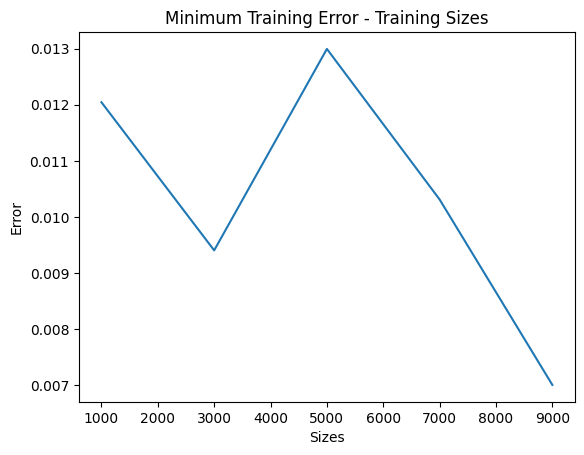

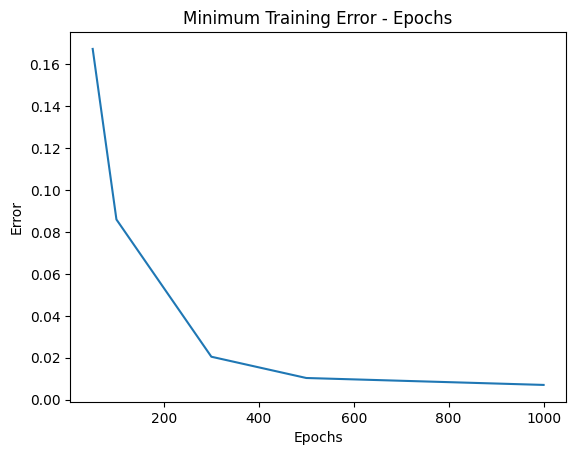

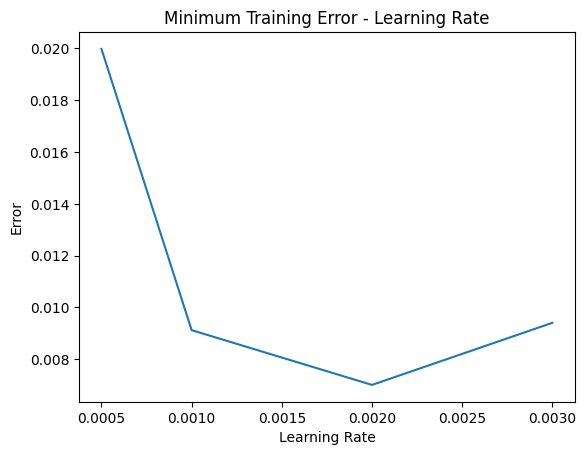

In [5]:
X_train_moon, _ = make_moons(10000, noise=0.1)
X_train_moon = torch.from_numpy(X_train_moon).type(torch.float32)

X_test_moon, _ = make_moons(10000, noise=0.1)
X_test_moon = torch.from_numpy(X_test_moon).type(torch.float32)


errors = test_hyperparameters(X_train_moon, X_test_moon, 1, 20, 3, training_parameters)

best_training_size = training_parameters[0][np.argmin(np.min(errors, axis=(1, 2)))]
best_epochs = training_parameters[1][np.argmin(np.min(errors, axis=(0, 2)))]
best_lr = training_parameters[2][np.argmin(np.min(errors, axis=(0, 1)))]

print(f'best combination: size = {best_training_size}, epochs = {best_epochs}, lr = {best_lr}')

for i, p in enumerate(possible_parameters):
    plot_min_for_parameter(training_parameters[i], errors, p)



### Training Size

We observe the best result for the most instances, however there is an increase in the middle, probably due to a bad initialization.

### Epochs

We see a monotonic decrease in the error as expected.

### Learning Rate

It seems as if a sweet spot is around 0.002, but for some runs we also had 0.003

In [6]:
hidden_sizes = [10, 15, 20, 40, 50]
layer_sizes = [1, 2, 3, 4]

def test_network_structure(X_train, X_test, bottleneck_size, hidden_sizes, layer_sizes, epochs, lr):

    input_size = X_train.shape[1]

    # create data array
    errors = np.zeros((len(hidden_sizes), len(layer_sizes)))

    for i, h in tqdm(enumerate(hidden_sizes), total=len(hidden_sizes)):
        for j, l in enumerate(layer_sizes):

            model = AutoEncoder(input_size, bottleneck_size, h, l)

            train_autoencoder(model, X_train, epochs, lr)

            output = model(X_test)

            errors[i, j] = torch.nn.MSELoss()(X_test, output)


    return errors


errors = test_network_structure(X_train_moon, X_test_moon, 1, hidden_sizes, layer_sizes, best_epochs, best_lr)

best_hidden_size = hidden_sizes[np.argmin(np.min(errors, axis=1))]
best_layer_count = layer_sizes[np.argmin(np.min(errors, axis=0))]
print(f'best network: hidden: {best_hidden_size}, layer count: {best_layer_count}')

100%|██████████| 5/5 [03:04<00:00, 36.95s/it]

best network: hidden: 50, layer count: 4


## Original vs. Reconstructions

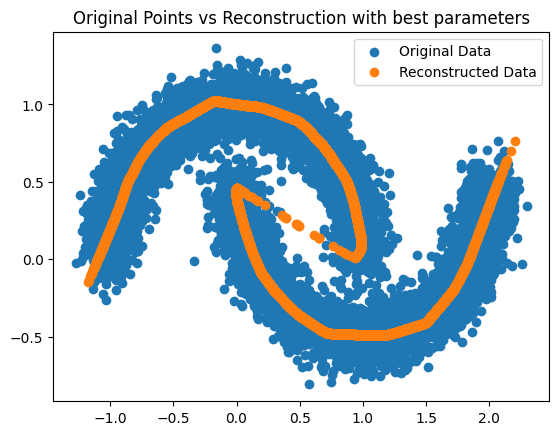

In [7]:
best_model_moons = AutoEncoder(2, 1, best_hidden_size, best_layer_count)
train_autoencoder(best_model_moons, X_train_moon[:best_training_size], best_epochs, best_lr)

out = best_model_moons(X_test_moon)

a = plt.scatter(X_test_moon[:, 0], X_test_moon[:, 1])
b = plt.scatter(out[:, 0].detach().numpy(), out[:, 1].detach().numpy())
plt.title("Original Points vs Reconstruction with best parameters")
plt.legend([a, b],["Original Data", "Reconstructed Data"])
plt.show()

As expected of a bottleneck of 1, the reconstructions follow a line. The reconstruction line lies in the middle of the two moons with a connection, that is sampled although there are no original points between the moons.

## Comments:
1.Implementing batch training can enhance the efficiency of the training process, especially for larger datasets.<br>
2.Incorporating tools like TensorBoard can provide more insightful visualizations and real-time monitoring of the training process.<br>
3.The nested loop structure for testing hyperparameters, while functional, can be optimized further, potentially using more advanced techniques like grid search or random search.<br>
4.More detailed comments on the implications of the findings, especially how they relate to the two moons dataset's specific characteristics, would be valuable.<br>
5.The analysis of the "sweet spot" for learning rates and the effect of epochs on error reduction shows a good understanding of model training techniques.


## Repeated training with best parameters and variance in errors

In [8]:
# same training data
errors_same = []
for i in trange(2):
    model = AutoEncoder(2, 1, best_hidden_size, best_layer_count)
    train_autoencoder(model, X_train_moon[:best_training_size], best_epochs, best_lr)

    errors_same.append(torch.nn.MSELoss()(X_test_moon, model(X_test_moon)).detach())


# varying training data
errors_var = []
for i in trange(2):
    X_var, _ = make_moons(10000, noise=0.1)
    X_var = torch.from_numpy(X_var).type(torch.float32)

    model = AutoEncoder(2, 1, 100, 2)
    train_autoencoder(model, X_var[:best_training_size], best_epochs, best_lr)

    errors_var.append(torch.nn.MSELoss()(X_test_moon, model(X_test_moon)).detach())

    mean_same = np.mean(errors_same)
std_same = np.std(errors_same)

mean_var = np.mean(errors_var)
std_var = np.std(errors_var)

df = pd.DataFrame([
    {'Mean': mean_same, 'Std. Dev.': std_same},
    {'Mean': mean_var, 'Std. Dev.': std_var}]).rename({'A': 'Mean', 'B': 'Std. Dev.'}).rename({0: "Same Dataset", 1: "Varying Dataset"})

print(df)

100%|██████████| 2/2 [00:47<00:00, 23.96s/it]

                     Mean  Std. Dev.
Same Dataset     0.009303   0.002800
Varying Dataset  0.006200   0.000208


Against our intuition the same dataset is on average better in terms of mean and std. dev.
This tells us, that the specific dataset we got here is not very good and on average a dataset is better suited for training.

## Comments:
1. Including plots for each training iteration, similar to the sample's approach, would provide a more intuitive understanding of the model's performance.<br>
2.Above code observes better performance on average with varying datasets than with the same dataset.This could indicate that the specific dataset used for the repeated training might not be very representative or that the model is robust to variations in the input data.<br>
3.Investigating why the model performs differently on varying datasets compared to a constant dataset could uncover more insights about the model's learning capabilities.

## Histogram, GMM fitting, sampling

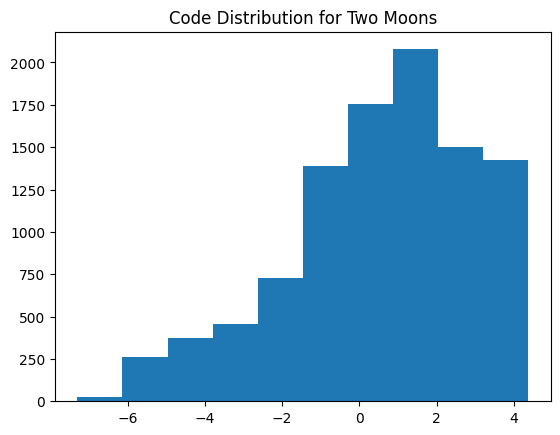

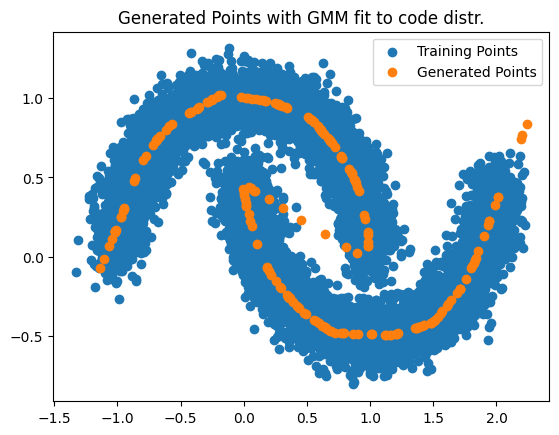

In [9]:
training_codes = best_model_moons.encode(X_train_moon)

plt.hist(training_codes.detach().numpy())
plt.title("Code Distribution for Two Moons")
plt.show()


gmm = GaussianMixture(5)
gmm.fit(training_codes.detach())

generated_codes, _ = gmm.sample(200)
generated_codes = torch.from_numpy(generated_codes).type(torch.float32)

generated_points = best_model_moons.decode(generated_codes).detach().numpy()

original = plt.scatter(X_train_moon[:, 0], X_train_moon[:, 1])
gen = plt.scatter(generated_points[:, 0], generated_points[:, 1])
plt.legend([original, gen], ["Training Points", "Generated Points"])
plt.title("Generated Points with GMM fit to code distr.")
plt.show()

The quality is good, except for some points.
The original data has noise, so the original points do not follow one line, but are distributed around the center line of the moons. The autoencoder only has a bottleneck of one, so this creates the codes only on a line. 
With this all of the decoded codes must follow a line in some way. The more powerful the model is, the more detailed the line the generated data follows becomes. For a very overpowered model, it could probably overfit and interpolate all points perfectly.
The line the data follows thus would follow a zig zag pattern through the main moons to hit as many points as possible.

Also there exists a connection between the two moons in the center. As the codes only have one connection, the generating line has no gaps, only different slopes for the code distribution. This means there are few codes between the moons and the most are clustered inside the moons.

The GMM is probably able to spot the position between the oons and tends to avoid it.

## Comments:
- 1.Experimenting with different numbers of components in the GMM could provide insights into how well the model can capture the data distribution.  

- 2.Exploring how changes in the autoencoder's complexity (like increasing the bottleneck size) affect the generated data could be insightful.  

- 3.The understanding that the GMM helps in avoiding the generation of points in less dense areas between the two moons is astute.This shows an appreciation for how the GMM's components can capture the underlying structure of the data.Good implementation of GMM.

## Model Testing with higher noise without retraining

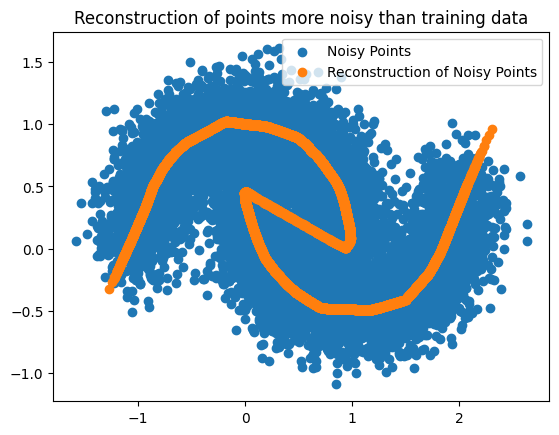

In [10]:
# check on noise 0.2
X_test_moon_noise, _ = make_moons(10000, noise=0.2)
X_test_moon_noise = torch.from_numpy(X_test_moon_noise).type(torch.float32)

reconstructed_noisy_points = best_model_moons(X_test_moon_noise).detach()

original = plt.scatter(X_test_moon_noise[:, 0], X_test_moon_noise[:, 1])
gen = plt.scatter(reconstructed_noisy_points[:, 0], reconstructed_noisy_points[:, 1])
plt.legend([original, gen], ["Noisy Points", "Reconstruction of Noisy Points"])
plt.title("Reconstruction of points more noisy than training data")
plt.show()

The reconstruction seems still to behave fairly good, the codes are in the area of a useful decoding.

## Comments:
1.Should consider applying the same scaling transformation to the noisy test data as was applied to the training data. This ensures a consistent basis for evaluating the autoencoder's performance.As here no scaling is applied to the noisy data.<br>
2.Incorporating quantitative metrics, such as reconstruction error, could provide a more objective assessment of the autoencoder's performance on noisy data.<br>


## Retraining with more noise

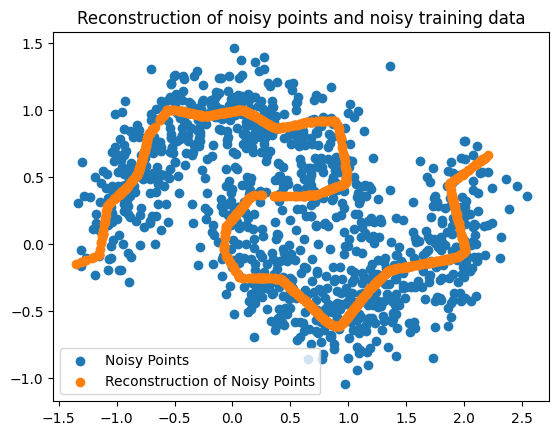

In [11]:
# autoencoder with noisier training set
X_train_moon_noise, _ = make_moons(1000, noise=0.2)
X_train_moon_noise = torch.from_numpy(X_train_moon_noise).type(torch.float32)

model_noisy_training = AutoEncoder(2, 1, best_hidden_size, best_layer_count)
train_autoencoder(model_noisy_training, X_train_moon_noise[:best_training_size], best_epochs, best_lr)

reconstructed_noisy_points = model_noisy_training(X_train_moon_noise).detach()

original = plt.scatter(X_train_moon_noise[:, 0], X_train_moon_noise[:, 1])
gen = plt.scatter(reconstructed_noisy_points[:, 0], reconstructed_noisy_points[:, 1])
plt.legend([original, gen], ["Noisy Points", "Reconstruction of Noisy Points"])
plt.title("Reconstruction of noisy points and noisy training data")
plt.show()

Here we now see the line doint a lot of turns and does not respect the space between the two moons, as this reduced the error while training. Doesn't look like the moons tho

## Comments:
- 1. With noisier data, the reconstruction becomes more complex and less representative of the original clean data structure.  
- 2.Use  advanced techniques like the sample's use of MMD or other regularization methods could help in achieving a better balance between noise adaptation and maintaining the original data structure.

# 2 No bottleneck

In [12]:
def squared_exponential_kernel(x1, x2, h=1):
    return torch.exp(-torch.sum((x1 - x2) ** 2) / (2 * h))

def complete_mmd(X, Y, h=1, num_kernels=7):

    N = X.shape[0]
    M = Y.shape[0]

    XX_raw = torch.sum(torch.square(X[:, None] - X), axis=-1)
    XX = XX_raw[XX_raw != 0]

    YY_raw = torch.sum(torch.square(Y[:, None] - Y), axis=-1)
    YY = YY_raw[YY_raw != 0]

    XY = torch.sum(torch.square(X[:, None] - Y), axis=-1)

    current_h = h


    resultsXX = torch.zeros(num_kernels)
    resultsXX[0] = torch.sum(torch.exp(-XX / (2 * current_h)))

    resultsYY = torch.zeros(num_kernels)
    resultsYY[0] = torch.sum(torch.exp(-YY / (2 * current_h)))

    resultsXY = torch.zeros(num_kernels)
    resultsXY[0] = torch.sum(torch.exp(-XY / (2 * current_h)))

    for i in range(1, num_kernels):

        current_h *= 1/2
        resultsYY[i] = torch.sum(torch.exp(-YY / (2 * current_h)))
        resultsXY[i] = torch.sum(torch.exp(-XY / (2 * current_h)))
        resultsXX[i] = torch.sum(torch.exp(-XX / (2 * current_h)))

    

    return 1 / (N * (N-1)) * torch.sum(resultsXX) - 2 / (M * N) * torch.sum(resultsXY) + 1 / (M * (M - 1)) * torch.sum(resultsYY)


def mmd_reconstruction_loss(X_true, X_gen, Z_true, Z_gen, h, num_kernels, l):

    return (1 - l) * torch.nn.MSELoss()(X_true, X_gen) + l * complete_mmd(Z_true, Z_gen, h, num_kernels)

In [13]:
# hyperparameters: training set size, number epochs, learning rate
def train_mmd_autoencoder(model, X_train, epochs=10, lr=0.001, l=0.5):
    
    optim = torch.optim.Adam(model.parameters(), lr)

    for i in range(epochs):

        codes = model.encode(X_train)
        output = model.decode(codes)
        error = mmd_reconstruction_loss(X_train, output, torch.randn_like(codes), codes, 1, 3, l)

        model.zero_grad()
        error.backward()

        optim.step()

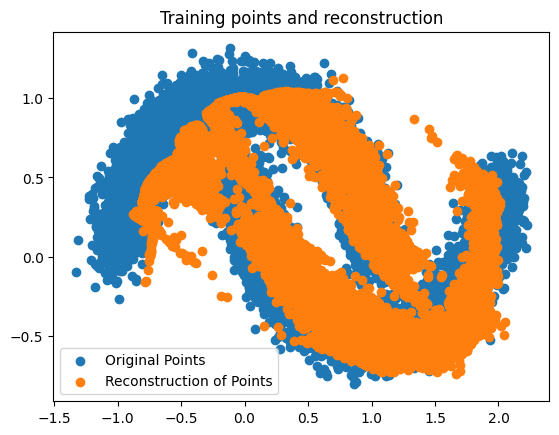

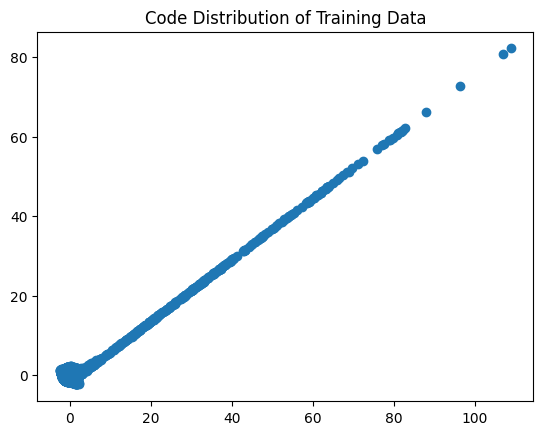

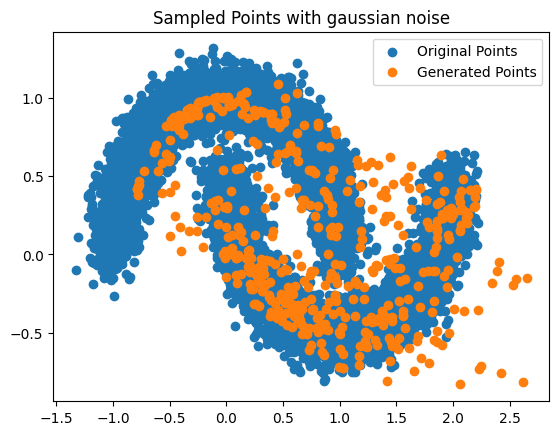

In [16]:
model_mmd = AutoEncoder(2, 2, best_hidden_size, best_layer_count)
train_mmd_autoencoder(model_mmd, X_train_moon[:2000], best_epochs, best_lr, 0.999)


training_codes = model_mmd.encode(X_train_moon).detach()
reconstructed_points = model_mmd.decode(training_codes).detach()

original = plt.scatter(X_train_moon[:, 0], X_train_moon[:, 1])
gen = plt.scatter(reconstructed_points[:, 0], reconstructed_points[:, 1])
plt.legend([original, gen], ["Original Points", "Reconstruction of Points"])
plt.title("Training points and reconstruction")
plt.show()


plt.scatter(training_codes[:, 0], training_codes[:, 1])
plt.title("Code Distribution of Training Data")
plt.show()



sampled_codes = torch.randn((500, 2))
generated_points = model_mmd.decode(sampled_codes).detach()

original = plt.scatter(X_train_moon[:, 0], X_train_moon[:, 1])
gen = plt.scatter(generated_points[:, 0], generated_points[:, 1])
plt.legend([original, gen], ["Original Points", "Generated Points"])
plt.title("Sampled Points with gaussian noise")
plt.show()

The reconstruction seems to work up to some degree, but is shifted. However as we have a bottleneck of two, the codes are not restricted as a line, but can be placed in 2D. 

Although we compared the output of the MMD function to other implementations with same outputs, the codes do not behave like a standard normal distribution. Maybe we selected the lambda not correctly for this case or the bandwidth.

The generated points are in a correct interval (more or less), but do not look too good. This was to be expected as the codes do not behave like a standard normal.

## Comments:
- 1.The  implementation the MMD loss using a series of exponential kernels is slightly different from the sample's, who uses inverse multi-quadratic kernels.  

- 2.Consider using a ResNet architecture, as in the sample's code, which might offer better performance for this complex dataset.<br>  

- 3.Using quantitative metrics like KL divergence to measure how closely the code distribution matches a standard normal distribution.<br>  

- 4.Experiment with different values of lambda and bandwidths in the MMD loss to find a more optimal balance between the reconstruction error and the standard normal distribution in the latent space.<br>


# 3 Higher-dimensional data

In [32]:
from sklearn.datasets import load_digits

digit_dataset = load_digits()

X = digit_dataset['data']
Y = digit_dataset['target']

permutation = torch.randperm(X.shape[0])

X = torch.from_numpy(X).type(torch.float32)[permutation]
Y = torch.from_numpy(Y).type(torch.float32)[permutation]

X_train_digit = X[:(X.shape[0]*2) // 3]
Y_train_digit = Y[:(Y.shape[0]*2) // 3]

X_test_digit = X[(X.shape[0]*2) // 3:]
Y_test_digit = Y[(Y.shape[0]*2) // 3:]

In [33]:
training_parameters = [
    [300, 500, 800, 1000],
    [50, 100, 300, 500, 1000],
    [0.003, 0.002, 0.001, 0.0005]
]


def test_hyperparameters(X_train, X_test, bottleneck_size, hidden_size, layers, training_parameters):

    N, input_size = X_train.shape

    # create data array
    errors = np.zeros((len(training_parameters[0]), len(training_parameters[1]), len(training_parameters[2])))

    for i, s in tqdm(enumerate(training_parameters[0]), total=len(training_parameters[0])):
        for j, e in enumerate(training_parameters[1]):
            for k, l in enumerate(training_parameters[2]):

                model = AutoEncoder(input_size, bottleneck_size, hidden_size, layers)

                train_autoencoder(model, X_train[:s], e, l)

                output = model(X_test)

                errors[i, j, k] = torch.nn.MSELoss()(X_test, output)


    return errors

100%|██████████| 4/4 [01:40<00:00, 25.19s/it]

best combination: size = 1000, epochs = 1000, lr = 0.002


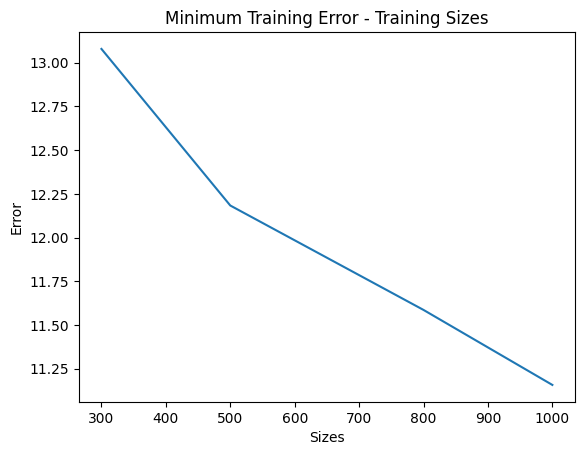

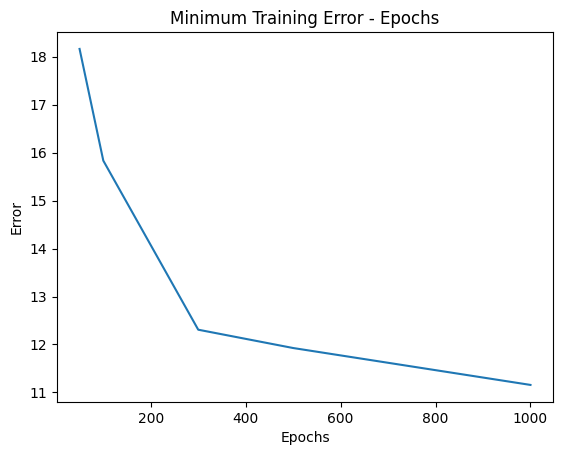

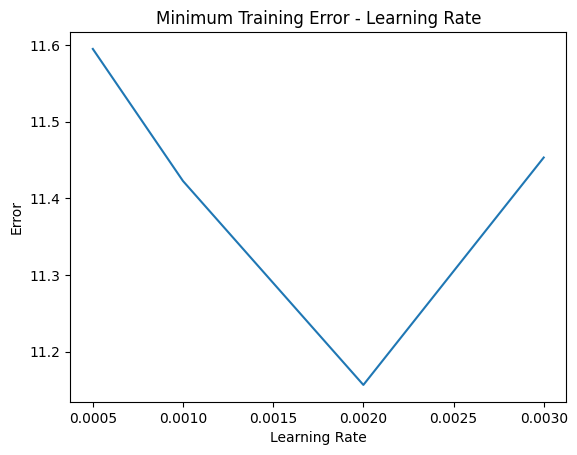

In [34]:
errors = test_hyperparameters(X_train_digit, X_test_digit, 2, 65, 1, training_parameters)

best_training_size_digits = training_parameters[0][np.argmin(np.min(errors, axis=(1, 2)))]
best_epochs_digits = training_parameters[1][np.argmin(np.min(errors, axis=(0, 2)))]
best_lr_digits = training_parameters[2][np.argmin(np.min(errors, axis=(0, 1)))]

print(f'best combination: size = {best_training_size_digits}, epochs = {best_epochs_digits}, lr = {best_lr_digits}')

for i, p in enumerate(possible_parameters):
    plot_min_for_parameter(training_parameters[i], errors, p)

In [41]:
hidden_sizes = [65, 70, 80, 100]
layer_sizes = [1, 2, 3, 4]

def test_network_structure(X_train, X_test, bottleneck_size, hidden_sizes, layer_sizes, epochs, lr):

    N, input_size = X_train.shape

    # create data array
    errors = np.zeros((len(hidden_sizes), len(layer_sizes)))

    for i, h in tqdm(enumerate(hidden_sizes), total=len(hidden_sizes)):
        for j, l in enumerate(layer_sizes):

            model = AutoEncoder(input_size, bottleneck_size, h, l)

            train_autoencoder(model, X_train[:N], epochs, lr)

            output = model(X_test)

            errors[i, j] = torch.nn.MSELoss()(X_test, output)


    return errors

In [42]:
errors = test_network_structure(X_train_digit, X_test_digit, 2, hidden_sizes, layer_sizes, best_epochs_digits, best_lr_digits)

best_hidden_size_digits = hidden_sizes[np.argmin(np.min(errors, axis=1))]
best_layer_count_digits = layer_sizes[np.argmin(np.min(errors, axis=0))]
print(f'best network: hidden: {best_hidden_size_digits}, layer count: {best_layer_count_digits}')

100%|██████████| 4/4 [01:47<00:00, 26.81s/it]

best network: hidden: 100, layer count: 2


torch.Size([599, 64])


100%|██████████| 3/3 [00:18<00:00,  6.06s/it]

best bottleneck: 8


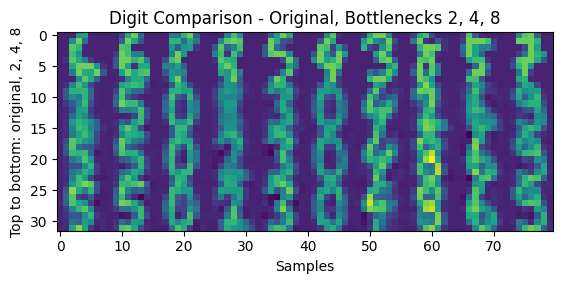

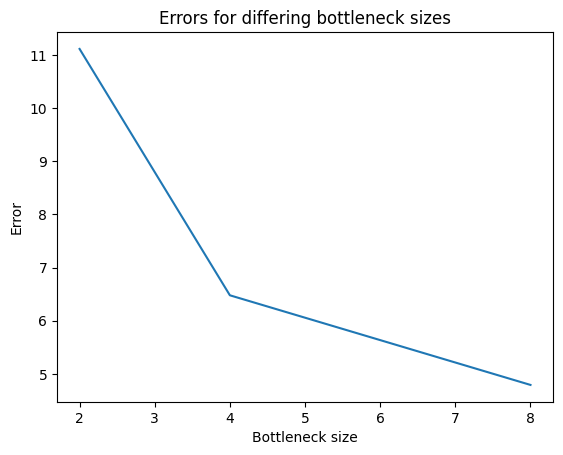

In [43]:
bottleneck_sizes = [2, 4, 8]

def test_bottleneck(X_train, X_test, bottleneck_sizes, hidden_size, layer_count, epochs, lr):

    N, input_size = X_train.shape

    # create data array
    errors = np.zeros((len(bottleneck_sizes)))

    reconstructed = np.zeros((len(bottleneck_sizes), 10, 8*8))

    for i, bn in tqdm(enumerate(bottleneck_sizes), total=len(bottleneck_sizes)):

            model = AutoEncoder(input_size, bn, hidden_size, layer_count)

            train_autoencoder(model, X_train, epochs, lr)

            output = model(X_test)

            reconstructed[i] = output[:10].detach().numpy()

            errors[i] = torch.nn.MSELoss()(X_test, output)


    return errors, reconstructed

print(X_test_digit.shape)
errors, reconstructed = test_bottleneck(X_train_digit[:best_training_size_digits], X_test_digit, bottleneck_sizes, best_hidden_size_digits, best_layer_count_digits, best_epochs_digits, best_lr_digits)

best_bottleneck_size_digits = bottleneck_sizes[np.argmin(errors)]

print(f'best bottleneck: {best_bottleneck_size_digits}')

reconstructed = reconstructed.reshape(3, 10, 8, 8).swapaxes(1, 2).reshape(3*8, 10*8)

plt.imshow(np.vstack([X_train_digit[:10].reshape(10, 8, 8).swapaxes(0, 1).reshape(8, 8*10), reconstructed]))
plt.title("Digit Comparison - Original, Bottlenecks 2, 4, 8")
plt.xlabel("Samples")
plt.ylabel("Top to bottom: original, 2, 4, 8")
plt.show()


plot_line("Errors for differing bottleneck sizes", bottleneck_sizes, errors, "Bottleneck size", "Error")


The numbers are not correct, however the results look somewhat like convincing numbers. But they changed the value for all bottlenecks.
However we had runs, where the results were better than this. No time

### Bottleneck 2
This one is the most blurry.

### Bottleneck 4
The numbers here are the most balanced, but still incorrect.

### Bottleneck 8
The numbers are very similar to bottleneck size 4.

In [44]:
classifier = RandomForestClassifier()
classifier.fit(X_train_digit, Y_train_digit)

model_digits = AutoEncoder(8*8, best_bottleneck_size_digits, best_hidden_size_digits, best_layer_count_digits)
train_autoencoder(model_digits, X_train_digit, best_epochs_digits, best_lr_digits)

X_test_digit_reconstructed = model_digits(X_test_digit)


# classify both sets

predictions_true = classifier.predict(X_test_digit.detach())
predictions_reconst = classifier.predict(X_test_digit_reconstructed.detach())

same_predictions = predictions_true == predictions_reconst
print(f'The labels match with {(np.mean(same_predictions) * 100):.2f}%')

The labels match with 92.15%


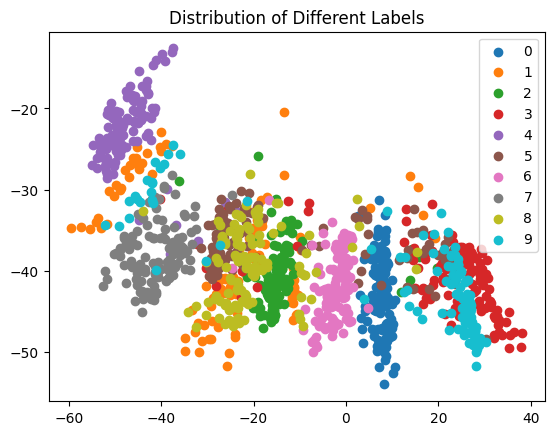

In [45]:
model_digits_two = AutoEncoder(8*8, 2, best_hidden_size_digits, best_layer_count_digits)
train_autoencoder(model_digits_two, X_train_digit, best_epochs_digits, best_lr_digits)

digit_codes = model_digits_two.encode(X_train_digit).detach()

plots = []
names = []

for i in range(10):
    relevant_codes = digit_codes[Y_train_digit == i]
    plot = plt.scatter(relevant_codes[:, 0], relevant_codes[:, 1])
    plots.append(plot)
    names.append(f'{i}')

plt.legend(plots, names)
plt.title("Distribution of Different Labels")
plt.show()

We can see, that the codes of the same numbers are clustered together mostly. There are some outliers.

There are some clusters overlapping, for example on the right the light blue and red clusters overlap. These are 3 and 9. If one closes the upper part of the 3 it looks like a nine so this makes sense.
Also some numbers have multiple clusters located in different parts: The 1 seems to have two different versions, one between 4 and 7. These are probably the ones very sharp. Also there are ones overlapping with 8s. If an 8 is very thin, it almost looks like a 1 with this resolution.

The numbers are more or less centered around a point. It seems like the clusters are arranged circular around a common center.
Also we have 4 on one side and 3 with 9 on the other, probably we have a sorting of "sharp" and "round" numbers. 0 is also there so maybe its roundness.

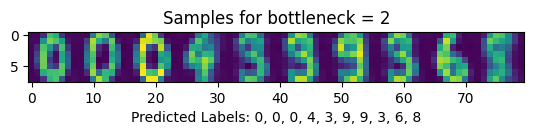

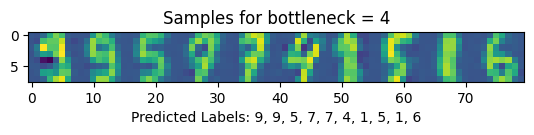

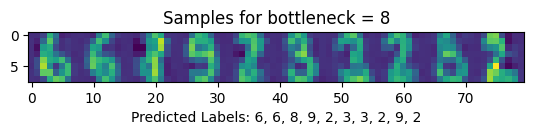

In [46]:
def gmm_plot_classify_bottleneck(X_train, X_test, bottleneck_sizes, hidden_size, layer_count, epochs, lr, classifier):

    N, input_size = X_train.shape

    # create data array
    errors = np.zeros((len(bottleneck_sizes)))


    for i, bn in enumerate(bottleneck_sizes):

            # train the model
            model = AutoEncoder(input_size, bn, hidden_size, layer_count)
            train_autoencoder(model, X_train, epochs, lr)


            # fit the gmm
            training_codes = model.encode(X_train).detach()

            gmm = GaussianMixture(5)
            gmm.fit(training_codes.detach())

            # generate synthetic data
            num_gen = 10
            generated_codes, _ = gmm.sample(num_gen)
            generated_codes = torch.from_numpy(generated_codes).type(torch.float32)

            generated_digits = model.decode(generated_codes).detach().numpy()
            predictions_gen = classifier.predict(generated_digits)

            # plot the images
            reconstructed = generated_digits
            plt.imshow(reconstructed.reshape(num_gen, 8, 8).swapaxes(0, 1).reshape(8, 8*num_gen))
            plt.title(f"Samples for bottleneck = {bn}")
            plt.xlabel(f"Predicted Labels: {', '.join([str(int(v)) for v in predictions_gen])}")
            plt.show()

gmm_plot_classify_bottleneck(X_train_digit, X_test_digit, bottleneck_sizes, best_hidden_size_digits, best_layer_count_digits, best_epochs_digits, best_lr_digits, classifier)

### Bottleneck 2

The numbers are very clear, even the blurries on the right can be recognized as a 9 or 5, but not clearly.
The classifier is very close to our interpretation.

### Bottleneck 4

The background of the numbers is not as pronounced as for bottleneck 2. The numbers are still good.
The classifier is also close to our prediction, except for the 4th sample that could be a 9 or 7.

### Bottleneck 8

The background is not as good as for size 2, but better than for size 4. The numbers still look mostly good, but not as good as the others.
The numbers have lower quality in our opinion. The classifier mostly agrees with our predictions except for the 9th number, we would predict it to be a 8 or maybe a bad 3, but not a 9.

## Comments:
- 1.The approach to generating and evaluating synthetic digits using GMMs adds an extra dimension to the analysis, especially in assessing the quality and classifiability of these synthetic digits.Good job.<br>  

- 2.A deeper analysis of the classifier's performance, including confusion matrices, could provide more detailed insights into which digits are more prone to misclassification after reconstruction.  
